In [1]:
!git clone https://github.com/tcm03/Vietnamese-image-captioning.git

Cloning into 'Vietnamese-image-captioning'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 131 (delta 38), reused 58 (delta 23), pack-reused 52 (from 1)
Receiving objects: 100% (131/131), 103.45 MiB | 55.61 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [2]:
%cd Vietnamese-image-captioning

/kaggle/working/Vietnamese-image-captioning


# Data

In [3]:
!mkdir -p /content/drive/MyDrive/IC/ResNet

In [4]:
!pip install transformers > /dev/null

In [5]:
!pip install gdown

In [7]:
# Tiny dataset

import os

# Full dataset with jpeg

!gdown https://drive.google.com/uc?id=1-xJoBvzwQKgJjPzHb3fq1sFicwyIisx7

!gdown https://drive.google.com/uc?id=1-ISSseaB-G7QAw0l9nJ63qKZGdH6OC0E

!unzip data_v1.zip -d /content/data > /dev/null

!unzip decoder_.zip -d /content/data > /dev/null

replace /content/data/decoder_1_epoch_10.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [8]:
import json

data = json.load(open("/content/data/train_data.json", "r"))

data['annotations'][0]

{'id': 0,
 'image_id': 2,
 'caption': 'ba chiếc thuyền đang di chuyển ở trên con sông',
 'segment_caption': 'ba chiếc thuyền đang di_chuyển ở trên con sông'}

# Vocab

In [9]:
import random

import numpy as np

import torch

import os

def set_random_seed(seed: int):

    random.seed(seed)

    np.random.seed(seed)

    torch.manual_seed(seed)

    torch.cuda.manual_seed(seed)

    torch.cuda.manual_seed_all(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)

In [10]:
set_random_seed(10)

In [11]:
from collections import Counter

import itertools

from itertools import count



class IMCP_Vocab():

  def __init__(self, texts) -> None:

    words = list(itertools.chain(*[text.split(" ") for text in texts]))

    counter = Counter(words)

    self.vocab = {key: i for i, key in zip(count(start = 4), counter.keys())}

    self.special_ids = [0, 1, 2, 3]

    self.max_seq_len = 256

    self.counter = counter

    self.special_tokens = ["<unk>", "<pad>", "<bos>", "<eos>"]

    for id, token in zip(self.special_ids, self.special_tokens):

      self.vocab[token] = id

    self.vocab = {k: v for k, v in sorted(self.vocab.items(), key=lambda x:x[1])}

    self.id2word = {v: k for k, v in self.vocab.items()}



    self.bos_token = "<bos>"

    self.eos_token = "<eos>"

    self.pad_token = "<pad>"

    self.unk_token = "<unk>"



  def get_vocab(self):

    return self.vocab



  def get_vocab_dump(self):

    vocab = dict()

    vocab['itos'] = list(vocab.keys())

    vocab['stoi'] = self.vocab

    vocab['freqs'] = dict(self.counter)

    return vocab



  def batch_decode(self, predictions_ids):

    preds = []

    for seq in predictions_ids:

        preds.append(" ".join([self.id2word[id] for id in seq if id not in [0,1,2,3,4,5]]))

    return preds

# Dataset

In [12]:
import torch

from torch.utils.data import DataLoader, Dataset

from PIL import Image

import json

import os



class IMCP_Dataset(Dataset):

  def __init__(self, image_path = "/content/data/train-images", summary_path = "/content/data/train_data.json", train = True):

    super().__init__()

    self.data = json.load(open(summary_path, "r"))

    self.image_path = image_path

    self.vocab = IMCP_Vocab(texts = [ann['segment_caption'] for ann in data['annotations']])

    self.imgid2imgname = {entry['id']: entry['filename'] for entry in data['images']}

    self.train = train



  def __len__(self):

    return len(self.data['annotations'])



  def __getitem__(self, index):

    if self.train:

      annotation = self.data['annotations'][index]

      image_id = annotation['image_id']

      image_name = self.imgid2imgname[image_id]

      image = Image.open(os.path.join(self.image_path, image_name)).convert('RGB')

      caption = annotation['segment_caption']

      return image, caption

    else:

      pass

In [13]:
train_dataset = IMCP_Dataset()

vocab = train_dataset.vocab

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.9, 0.1])

In [14]:
# Save vocab to file

with open("/content/drive/MyDrive/IC/ResNet/vocab.json", 'w+') as file:

  json.dump(vocab.get_vocab_dump(), file, ensure_ascii = False)

# Collator

In [15]:
from torch.nn.utils.rnn import pad_sequence

import torchvision.transforms as transforms



class IMCP_Collator:

  def __init__(self, vocab, train = True):

    self.vocab = vocab

    self.bos_id = self.vocab.get_vocab()['<bos>']

    self.eos_id = self.vocab.get_vocab()['<eos>']

    self.pad_id = self.vocab.get_vocab()['<pad>']



  def tokenize_texts(self, captions):

    raw_captions = [caption.split(" ") for caption in captions]

    truncated_captions = [s[:self.vocab.max_seq_len] for s in raw_captions]

    max_len = max([len(c) for c in truncated_captions])



    padded_captions = []

    for c in truncated_captions:

        c = [self.vocab.get_vocab()[word] for word in c]

        seq = [self.bos_id] + c + [self.eos_id] + [self.pad_id] * (max_len - len(c))

        padded_captions.append(seq)



    padded_captions = [torch.Tensor(seq).long() for seq in padded_captions]

    padded_captions = pad_sequence(padded_captions, batch_first=True)

    return padded_captions



  def resize_and_stack(self, images):

    # new_size = (224, 224)

    image_tensors = []

    transform = transforms.Compose([

        transforms.Resize((224, 224)),

        transforms.ToTensor(),

    ])



    for image in images:

      img_tensor = transform(image)

      image.close()

      image_tensors.append(img_tensor)



    stacked = torch.stack(image_tensors)

    return stacked



  def __call__(self, batch):

    images = [example[0] for example in batch]

    captions = [example[1] for example in batch]

    return {

        'images': self.resize_and_stack(images),

        'captions': self.tokenize_texts(captions)

    }


In [16]:
collator = IMCP_Collator(vocab, train = True)

# DataLoader

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True,  collate_fn = collator, pin_memory=True, drop_last = True, num_workers=4)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False,  collate_fn = collator, pin_memory=True, drop_last = True, num_workers=4)

# Model

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from transformers import get_cosine_schedule_with_warmup

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_type="cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True  # Optimizes for constant input sizes

# Load pre-trained ResNet101 model
encoder = models.resnet101(pretrained=True).to(device)
# Remove the last layer of the model
modules = list(encoder.children())[:-1]
encoder = nn.Sequential(*modules)
# Freeze the parameters of the model
for param in encoder.parameters():
    param.requires_grad = False

# Initialize parameters
def init(module):
    for name, param in module.named_parameters():
        if 'weight' in name:
            nn.init.xavier_normal_(param.data)
        else:
            nn.init.constant_(param.data, 0)
    return module

# Define LSTM decoder
class Decoder(nn.Module):
    def __init__(self, feature_size, embed_size, hidden_size, vocab_size, num_layers, dropout=0.0):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size + feature_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        captions = captions[:, :-1]
        embeddings = self.embed(captions)
        features = features.squeeze().unsqueeze(1).repeat(1, embeddings.size(1), 1)
        embeddings = torch.cat((features, embeddings), 2)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

# Define hyperparameters
num_epochs = 10
embed_size = 256
feature_size = 2048
hidden_size = 512
vocab_size = len(collator.vocab.get_vocab()) + 5
total_step = num_epochs * len(train_dataloader)

# Tuning hyperparameters
num_layers = 1
dropout = 0.0

# Initialize decoder
decoder = Decoder(feature_size, embed_size, hidden_size, vocab_size, num_layers, dropout).to(device)
decoder.apply(init)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Creating optimizer and learning rate scheduler
param_optimizer = list(decoder.parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer = torch.optim.AdamW(param_optimizer, lr=0.001, weight_decay=0.001)
lr_scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * total_step, num_training_steps=total_step)

# Initialize mixed precision training
scaler = torch.amp.GradScaler(device_type)

# Train the model
for epoch in range(num_epochs):
    print(f"Start Epoch {epoch + 1}")
    decoder.train()
    for i, data in enumerate(train_dataloader):
        # Move data to GPU
        images = data['images'].to(device, non_blocking=True)
        captions = data['captions'].to(device, non_blocking=True)

        # Forward pass with mixed precision
        with torch.amp.autocast(device_type=device_type):
            features = encoder(images)
            outputs = decoder(features, captions)
            loss = criterion(outputs.permute(0, 2, 1), captions[:, 1:])

        # Backward pass and optimization
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()

        # Print loss
        if i % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    # Validation phase
    decoder.eval()
    valid_loss = []
    with torch.no_grad():
        for i, data in enumerate(valid_dataloader):
            images = data['images'].to(device, non_blocking=True)
            captions = data['captions'].to(device, non_blocking=True)

            with torch.amp.autocast(device_type=device_type):
                features = encoder(images)
                outputs = decoder(features, captions)
                loss = criterion(outputs.permute(0, 2, 1), captions[:, 1:])
            valid_loss.append(loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss: {np.mean(valid_loss):.4f}')


In [100]:
torch.save(encoder.state_dict(), '/kaggle/working/encoder_1_epoch_10.pth')

torch.save(decoder.state_dict(), '/kaggle/working/decoder_1_epoch_10.pth')

# Inference

In [17]:
%cd /content/data

!ls /content/data

/content/data
decoder_1_epoch_10.pth	public-test-images  train-images
decoder_2_epoch_15.pth	test_data.json	    train_data.json


In [18]:
import json
vocab = json.load(open("/content/drive/MyDrive/IC/ResNet/vocab.json", encoding = 'utf-8'))
itos = list(vocab['stoi'])

def batch_decode(predictions_ids):
    preds = []
    for seq in predictions_ids:
        preds.append(" ".join([itos[id] for id in seq if id not in [0,1,2,3]]))
    return preds

In [19]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import json
import os

class IMCP_Test_Dataset(Dataset):
  def __init__(self, image_path = "public-test-images", summary_path = "test_data.json"):
    super().__init__()
    self.data = json.load(open(summary_path, "r", encoding = 'utf-8'))
    self.image_path = image_path
    self.imgid2imgname = {entry['id']: entry['filename'] for entry in self.data['images']}

  def __len__(self):
    return len(self.data['images'])

  def __getitem__(self, index):
    entry = self.data['images'][index]
    image_id = entry['id']
    image_name = entry['filename']
    image = Image.open(os.path.join(self.image_path, image_name)).convert('RGB')
    caption = [self.data['annotations'][i]['segment_caption'] for i in range(len(self.data['annotations'])) if self.data['annotations'][i]['image_id'] == image_id]
    return image, caption, image_id

test_dataset = IMCP_Test_Dataset()

from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
max_seq_length = 256
class IMCP_Collator:
  def __init__(self, vocab, train = True, model = "resnet101"):
    self.vocab = vocab['stoi']
    self.bos_id = self.vocab['<bos>']
    self.eos_id = self.vocab['<eos>']
    self.pad_id = self.vocab['<pad>']
    self.model = model
    self.train = train

  def tokenize_texts(self, captions):
    raw_captions = [caption.split(" ") for caption in captions]
    truncated_captions = [s[:max_seq_length] for s in raw_captions]
    max_len = max([len(c) for c in truncated_captions])

    padded_captions = []
    for c in truncated_captions:
        c = [self.vocab[word] for word in c]
        seq = [self.bos_id] + c + [self.eos_id] + [self.pad_id] * (max_len - len(c))
        padded_captions.append(seq)

    padded_captions = [torch.Tensor(seq).long() for seq in padded_captions]
    padded_captions = pad_sequence(padded_captions, batch_first=True)
    return padded_captions

  def resize_and_stack(self, images):
    if self.model == "resnet101":
      image_tensors = []
      transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
      ])

      for image in images:
        img_tensor = transform(image)
        image.close()
        image_tensors.append(img_tensor)

      stacked = torch.stack(image_tensors)
      return stacked
    else:
      pass

  def __call__(self, batch):
    if self.train:
      images = [example[0] for example in batch]
      captions = [example[1] for example in batch]
      return self.resize_and_stack(images), self.tokenize_texts(captions)
    else:
      images = [example[0] for example in batch]
      captions = [example[1] for example in batch]
      image_ids = [example[2] for example in batch]
      return self.resize_and_stack(images), captions, image_ids

collatorTest = IMCP_Collator(vocab, train = False, model = "resnet101")
test_dataloader = DataLoader(test_dataset, batch_size = 16, collate_fn = collatorTest)

In [27]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet101 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = models.resnet101(pretrained=True).to(device)

# Remove the last layer of the model
modules = list(encoder.children())[:-1]
encoder = nn.Sequential(*modules)
encoder.eval()  # Set encoder to evaluation mode

# Freeze the parameters of the model
for param in encoder.parameters():
    param.requires_grad = False

# Define LSTM decoder
class Decoder(nn.Module):
    def __init__(self, feature_size, embed_size, hidden_size, vocab_size, num_layers, dropout=0.0):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size + feature_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        captions = captions[:, :-1]
        embeddings = self.embed(captions)
        features = features.squeeze().unsqueeze(1).repeat(1, embeddings.size(1), 1)
        embeddings = torch.cat((features, embeddings), 2)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

    def generate(self, features, max_length=50):
        batch_size = features.size(0)
        input = torch.full((batch_size, 1), collatorTest.bos_id, device=device, dtype=torch.long)
        track_complete_example = torch.zeros(batch_size, device=device, dtype=torch.bool)
        hidden = None
        cell = None

        with torch.no_grad():
            with torch.amp.autocast(device_type='cuda'):
                for t in range(max_length - 1):
                    embeddings = self.embed(input[:, -1:])
                    features2 = features.squeeze(-1).squeeze(-1).unsqueeze(1).repeat(1, embeddings.size(1), 1)
                    embeddings = torch.cat((features2, embeddings), 2)

                    if t == 0:
                        _, (hidden, cell) = self.lstm(embeddings)
                    else:
                        _, (hidden, cell) = self.lstm(embeddings, (hidden, cell))

                    pred = torch.argmax(self.linear(hidden[-1]), axis=-1, keepdim=True)
                    input = torch.cat([input, pred], dim=1)

                    # Mark sequences as complete if the end token is found
                    track_complete_example = track_complete_example | (pred.squeeze() == collatorTest.pad_id)
                    if track_complete_example.all():
                        break

        return input

# Define hyperparameters
embed_size = 256
feature_size = 2048
hidden_size = 512
vocab_size = len(vocab['stoi'].keys()) + 5

# Tuning hyperparameters
num_layers = 1
dropout = 0.0

# Initialize decoder
decoder = Decoder(feature_size, embed_size, hidden_size, vocab_size, num_layers, dropout).to(device)

decoder.load_state_dict(torch.load('decoder_1_epoch_10.pth'))

decoder.eval()  # Set decoder to evaluation mode

/tmp/ipykernel_30/2103691325.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder.load_state_dict(torch.load('decoder_1_epoch_10.pth'))


Decoder(
  (embed): Embedding(2349, 256)
  (lstm): LSTM(2304, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=2349, bias=True)
)

In [24]:
%cd /kaggle/working/Vietnamese-image-captioning

from metrics.cider.cider import Cider
from metrics.bleu.bleu import Bleu

%cd /content/data

/kaggle/working/Vietnamese-image-captioning
/content/data


# 1 layer of LSTM 10 epochs

In [28]:
import json
import torch

# Dictionaries to hold references and candidates
cand_dict = {}
ref_dict = {}

# Inference and dictionary creation
with torch.no_grad():
    for images, captions, image_ids in test_dataloader:
        print(captions)
        
        # Populate reference dictionary
        ref_dict.update(dict(zip(image_ids, captions)))

        # Move images to GPU for processing
        images = images.to(device)

        # Forward pass through encoder and decoder
        features = encoder(images)
        outputs = decoder.generate(features)

        # Decode predictions in a batch
        pred_captions = batch_decode(outputs.detach().cpu().numpy())

        # Populate candidate dictionary
        cand_dict.update(dict(zip(image_ids, [[caption] for caption in pred_captions])))

# Utility to save dictionaries to a JSON file
def save_dictionaries(ref_dict, cand_dict, file_path):
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)
    print(f"Dictionaries saved to {file_path}.")

# Save the dictionaries
file_path = "inference.json"

save_dictionaries(ref_dict, cand_dict, file_path)

# Utility to load dictionaries from a JSON file
def load_dictionaries(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    print(f"Dictionaries loaded from {file_path}.")
    return data["ref_dict"], data["cand_dict"]

# Evaluate using CIDEr, BLEU
scorers = [
    (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
    # (Meteor(),"METEOR"),
    # (Rouge(), "ROUGE_L"),
    (Cider(), "CIDEr"),
    # (Spice(), "SPICE")
]

for scorer, method in scorers:
    print("computing %s score..." % (scorer.method()))
    score, scores = scorer.compute_score(ref_dict, cand_dict)
    if type(method) == list:
        for sc, scs, m in zip(score, scores, method):
            print("%s: %0.3f" % (m, sc))
    else:
        print("%s: %0.3f" % (method, score))

[['đây là khung_cảnh xuất_hiện ở phía trước một căn nhà', 'có một căn nhà cao_tầng xuất_hiện ở trong bức ảnh', 'ở trong bức ảnh có sự xuất_hiện của một căn nhà cao_tầng', 'có một chiếc xe_máy xuất_hiện ở trong căn nhà', 'đây là bức ảnh chụp ở phía trước của một căn nhà cao_tầng'], ['có nhiều người đang múa ở trên phố đi bộ', 'có nhiều người đang biểu_diễn nghệ_thuật trên phố đi bộ', 'ở trên phố đi bộ có nhiều người đang biểu_diễn nghệ_thuật', 'ở trên phố đi bộ có nhiều người đang nhảy_múa', 'có nhiều người đang xuất_hiện ở trên phố đi bộ'], ['có một hòn đảo xuất_hiện ở trên bãi biển', 'ở trên biển có sự xuất_hiện của một hòn đảo', 'có một mũi_tên màu đỏ xuất_hiện trong bức ảnh', 'có những con tàu đang đậu trên biển trong bức ảnh ở góc dưới trái', 'ở góc dưới trái có một bức ảnh chụp những con tàu trên biển'], ['đây là khung_cảnh xuất_hiện trong một siêu_thị', 'có một người phụ_nữ mặc áo hoa đang nhìn lên các sản_phẩm trên quầy hàng', 'có một người phụ_nữ áo hoa xuất_hiện ở bên quầy hàn

# 2 layers of LSTM, 15 epochs

In [29]:
# Tuning hyperparameters
num_layers = 2
dropout = 0.5

# Initialize decoder
decoder = Decoder(feature_size, embed_size, hidden_size, vocab_size, num_layers, dropout).to(device)

decoder.load_state_dict(torch.load('decoder_2_epoch_15.pth'))

decoder.eval()  # Set decoder to evaluation mode

import json
import torch

# Dictionaries to hold references and candidates
cand_dict = {}
ref_dict = {}

# Inference and dictionary creation
with torch.no_grad():
    for images, captions, image_ids in test_dataloader:
        print(captions)
        
        # Populate reference dictionary
        ref_dict.update(dict(zip(image_ids, captions)))

        # Move images to GPU for processing
        images = images.to(device)

        # Forward pass through encoder and decoder
        features = encoder(images)
        outputs = decoder.generate(features)

        # Decode predictions in a batch
        pred_captions = batch_decode(outputs.detach().cpu().numpy())

        # Populate candidate dictionary
        cand_dict.update(dict(zip(image_ids, [[caption] for caption in pred_captions])))

# Utility to save dictionaries to a JSON file
def save_dictionaries(ref_dict, cand_dict, file_path):
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)
    print(f"Dictionaries saved to {file_path}.")

# Save the dictionaries
file_path = "inference.json"

save_dictionaries(ref_dict, cand_dict, file_path)

# Utility to load dictionaries from a JSON file
def load_dictionaries(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    print(f"Dictionaries loaded from {file_path}.")
    return data["ref_dict"], data["cand_dict"]

# Evaluate using CIDEr, BLEU
scorers = [
    (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
    # (Meteor(),"METEOR"),
    # (Rouge(), "ROUGE_L"),
    (Cider(), "CIDEr"),
    # (Spice(), "SPICE")
]

for scorer, method in scorers:
    print("computing %s score..." % (scorer.method()))
    score, scores = scorer.compute_score(ref_dict, cand_dict)
    if type(method) == list:
        for sc, scs, m in zip(score, scores, method):
            print("%s: %0.3f" % (m, sc))
    else:
        print("%s: %0.3f" % (method, score))


/tmp/ipykernel_30/1172769072.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder.load_state_dict(torch.load('decoder_2_epoch_15.pth'))


[['đây là khung_cảnh xuất_hiện ở phía trước một căn nhà', 'có một căn nhà cao_tầng xuất_hiện ở trong bức ảnh', 'ở trong bức ảnh có sự xuất_hiện của một căn nhà cao_tầng', 'có một chiếc xe_máy xuất_hiện ở trong căn nhà', 'đây là bức ảnh chụp ở phía trước của một căn nhà cao_tầng'], ['có nhiều người đang múa ở trên phố đi bộ', 'có nhiều người đang biểu_diễn nghệ_thuật trên phố đi bộ', 'ở trên phố đi bộ có nhiều người đang biểu_diễn nghệ_thuật', 'ở trên phố đi bộ có nhiều người đang nhảy_múa', 'có nhiều người đang xuất_hiện ở trên phố đi bộ'], ['có một hòn đảo xuất_hiện ở trên bãi biển', 'ở trên biển có sự xuất_hiện của một hòn đảo', 'có một mũi_tên màu đỏ xuất_hiện trong bức ảnh', 'có những con tàu đang đậu trên biển trong bức ảnh ở góc dưới trái', 'ở góc dưới trái có một bức ảnh chụp những con tàu trên biển'], ['đây là khung_cảnh xuất_hiện trong một siêu_thị', 'có một người phụ_nữ mặc áo hoa đang nhìn lên các sản_phẩm trên quầy hàng', 'có một người phụ_nữ áo hoa xuất_hiện ở bên quầy hàn

In [104]:
import matplotlib.pyplot as plt

def image_captioning(image_name: str):
    image = Image.open(image_name).convert('RGB')
    plt.imshow(image)
    images = collatorTest.resize_and_stack([image])
    images = images.to(device)
    features = encoder(images)
    out = decoder.generate(features, 30)
    preds = out.detach().cpu().numpy()
    plt.title(batch_decode(preds)[0])
    plt.show()

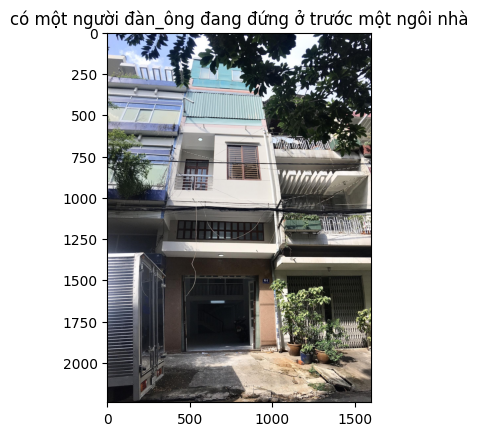

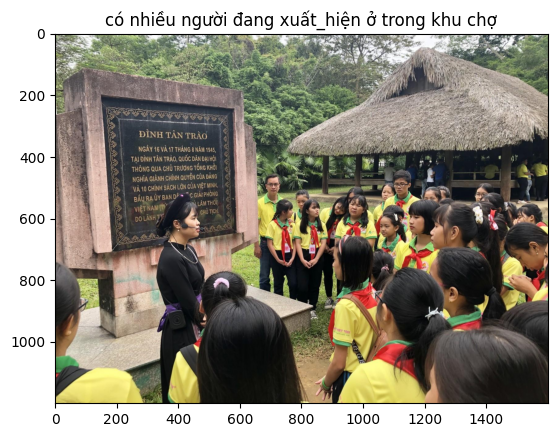

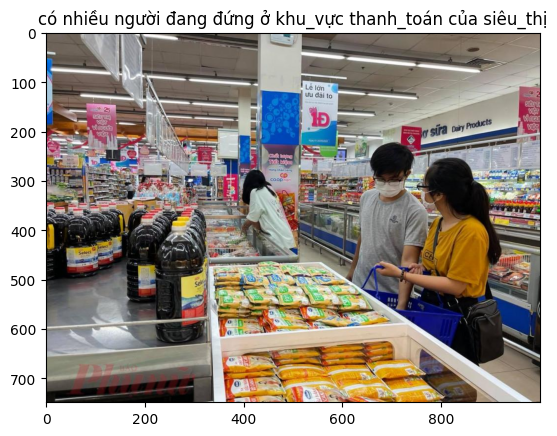

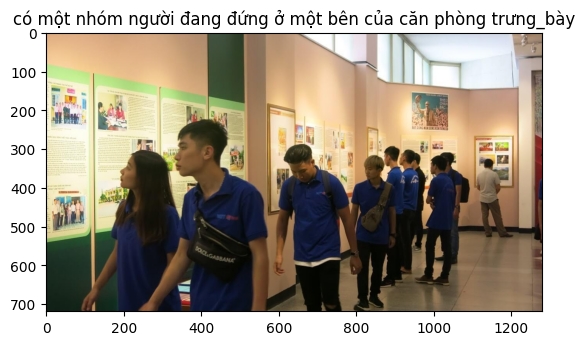

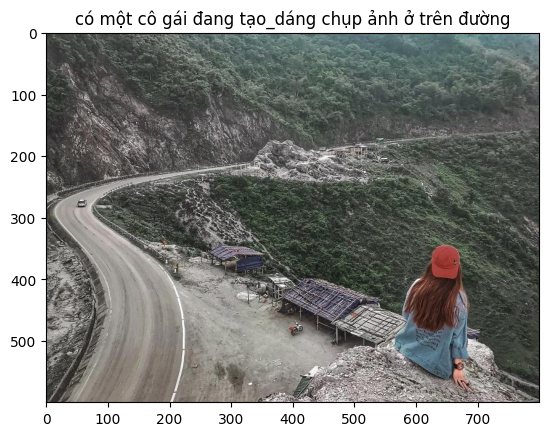

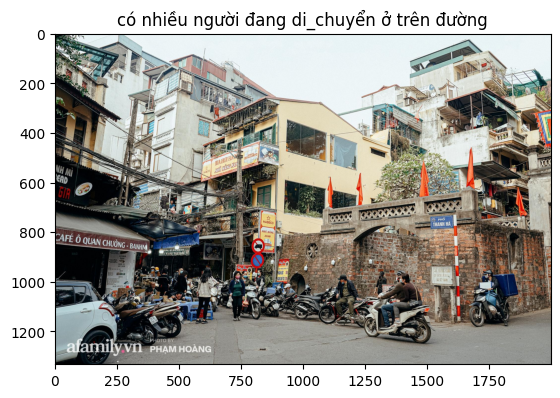

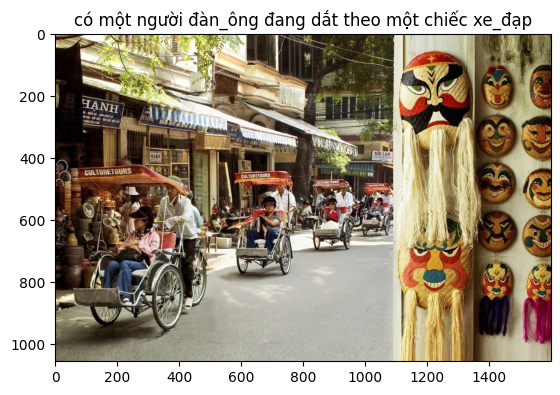

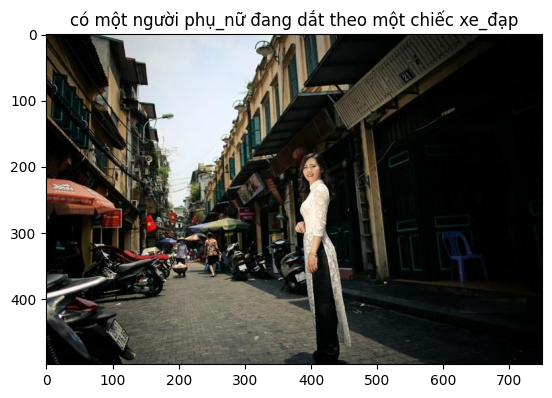

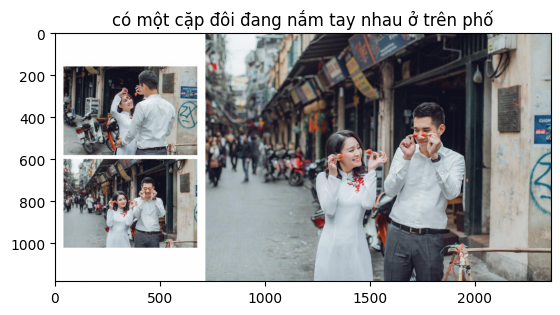

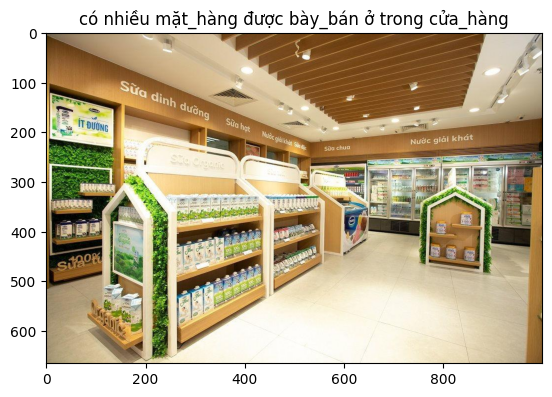

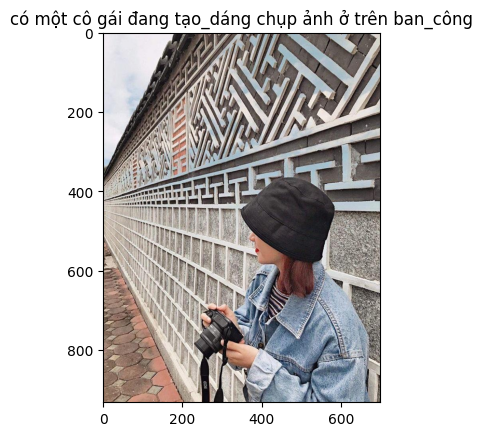

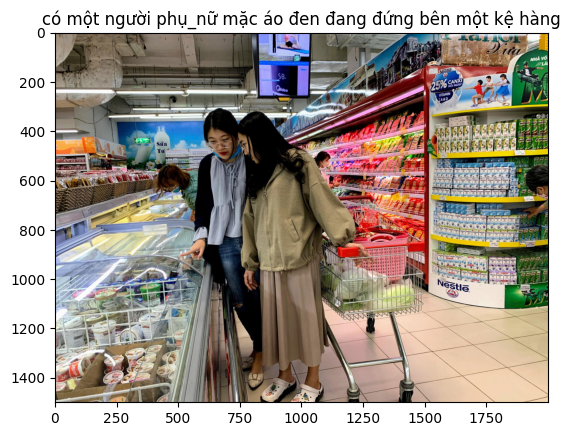

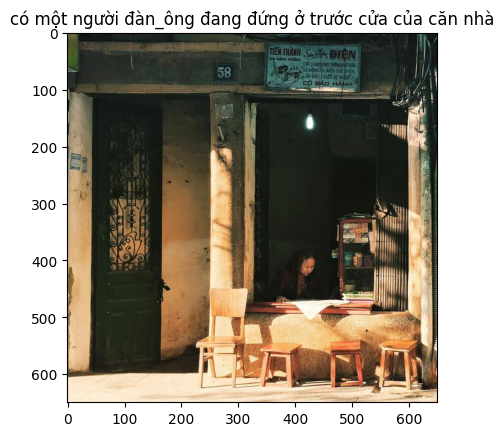

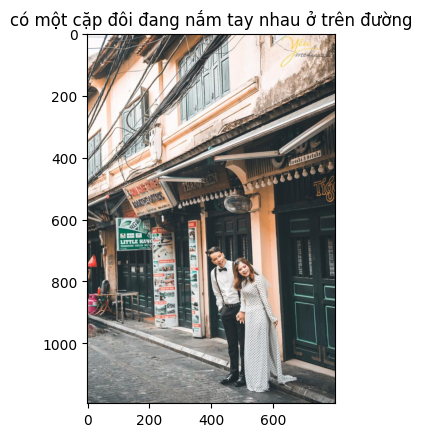

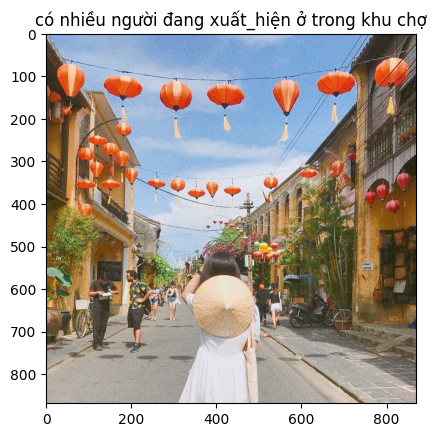

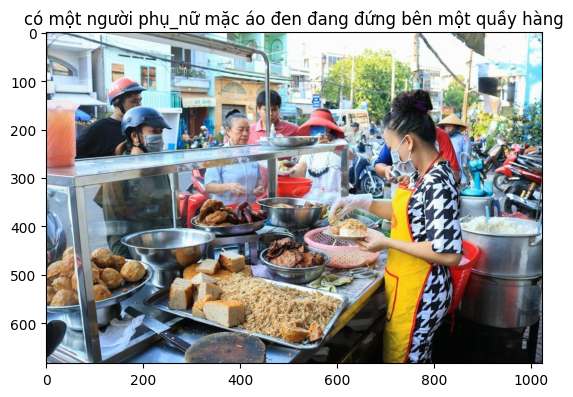

In [108]:
image_captioning("public-test-images/00000000001.jpg")
image_captioning("public-test-images/00000000078.jpg")
image_captioning("public-test-images/00000000115.jpg")
image_captioning("public-test-images/00000000118.jpg")
image_captioning("public-test-images/00000000190.jpg")
image_captioning("public-test-images/00000000322.jpg")
image_captioning("public-test-images/00000000331.jpg")
image_captioning("public-test-images/00000000363.jpg")
image_captioning("public-test-images/00000000490.jpg")
image_captioning("public-test-images/00000000657.jpg")
image_captioning("public-test-images/00000000702.jpg")
image_captioning("public-test-images/00000000834.jpg")
image_captioning("public-test-images/00000001052.jpg")
image_captioning("public-test-images/00000001109.jpg")
image_captioning("public-test-images/00000009770.jpg")
image_captioning("public-test-images/00000011015.jpeg")